# PART 2: MODELLING

## **Introduction**

### **Research objectives**

The main objective of this research is to develop 3 Machine Learning Models which are able to predict those with diabetes (gh >= 6.5%) with the best predictability rate. The end-user of this ML system will be the medical professionals and potentially the patients who would like to know whether they could be having diabetes. By accurately predicting diabetes, this predictive models will help to ensure prompt intervention on patients with diabetes, thus ensuring better life outcomes for the patients and avert uncecessary further financial burden due to delayed treatment.

### **Machine Learning Task and proposed models**

I will first need to create a target variable `has_diabetes` (tells us whether the patient is diabetic or not according to specified gh percentage), I will thus be adopting a supervised learning approach, since labels are already present, with a 70-30 train test split. To better explain the decision-making process behind each models (whether easily interpretable or not), I will also adopt the use of an Explainable-AI tool, which in my case is the SHAP, which stands for SHapley Additive exPlanations, which is to provide interpretable insights on how each of the feature impacts the model's decision making process. The benefit of such is that it can also educate the end-users on some of the key reasons and trends of identifying diabetes based on the unique attributes of patients. At the same time, it provides a human-over-the-loop monitoring for the team of data scientists/engineers to verify the decision-making process of the ML models, to ensure the ethics of AI and transparency of AI are upheld, especially important for the health sector. This is important to avert any biases in the model prediction.

Generally, the aim at the end of EDA process is to uncover key insights that will guide the modeling process and highlight the importance of each of the three ML models

Along the way in this notebook, we will also uncover some additional insights which will also aid us in the understanding of our data and how we frame our ML solutions to fulfill our research objectives.


**Predictive Performance (On test dataset) conclusion:**

| Model                     | Accuracy | AUC      | Recall   | Precision | F1 Score |
| ------------------------- | -------- | -------- | -------- | --------- | -------- |
| Lasso Logistic Regression | 0.904855 | 0.946421 | 0.829787 | 0.490566  | 0.616601 |
| Decision Tree             | 0.944090 | 0.818670 | 0.664894 | 0.710227  | 0.686813 |
| Random Forest             | 0.920549 | 0.939550 | 0.760638 | 0.550000  | 0.638393 |

1. Logistic Regression (Lasso-Penalised): I conclude that this is the best model, with the highest AUC score of 0.946 and highest Recall Score of 0.830 when fine-tuned and regularised to prevent overfitting. It is also highly interpretable.

2. Random Forest: I conclude that Random Forest Classifier is the second best model, with second highest AUC score and a decent recall of 0.761.

3. Decision Tree: Decision tree is the worst performing, with an AUC score being lowest and the recall score also the lowest. However, this is not to discredit this model as it is also highly explainable/interpretable. The AUC score and recall score can still be considered decent

**Conclusively, Logistic Regression (With Lasso Penalty) performs the best in terms of predictive performance.**

### **EXPLANATORY PERFORMANCE**

The differences in feature importance and SHAP plots between the Lasso Logistic Regression and the Random Forest/decision tree models are due to:

- The linear vs. non-linear nature of the models.
- The different methods of calculating feature importance.
- The handling of correlated features.

Consolidating the General findings from the lasso logistic regression model and random forest model SHAP models suggest that the following factors increases your risk of diabetes:

1. `tx` = 1, being treated with insulin/on diabetes med increases one risk of diabetes.

2. `dx` = 1, being diagnosed with PRE-DM or already diagnosed with DM increases risk of diabetes.

3. A higher `age`, being older, increases one's risk of diabetes.

4. A higher waistline circumference increases one's risk of diabetes.

5. If you are male individual, you are at an elevated risk of diabetes.

6. A lower income level may also elevate your risk of diabetes.

7. Having a lower albumin level also increases your risk of diabetes

**Conclusively, BOTH Logistic Regression (With Lasso Penalty) and RANDOM FOREST is a tie in terms of predictive performance since their decision making process is relatively different due to the linear (log reg) vs. non-linear (random forest) nature of the models.**


In [21]:
# Load relevant libraries

import pandas as pd
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine

import plotly.express as px
import plotly.graph_objects as go
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
from dash_table import DataTable, FormatTemplate


from datetime import datetime, date
from IPython.display import display


from pycaret.classification import *
from sklearn import datasets, linear_model, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    recall_score,
    precision_score,
    f1_score,
)
from ydata_profiling import ProfileReport
from scipy.stats import chi2_contingency
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm
from scipy import stats
import shap

In [8]:
# Create a SQLAlchemy engine
engine = create_engine("sqlite:///cleaned_data.db")

# Example of retrieving the entire table
cleaned_df = pd.read_sql_query("SELECT * FROM cleaned_data", engine)

# Display the cleaned_df information and info
display(cleaned_df.head())
display(cleaned_df.info())

,age,income,tx,dx,bmi,leg,armc,waist,sub,albumin,has_diabetes,sex_male,re_Non-Hispanic Black,re_Non-Hispanic White,re_Other Hispanic,re_Other Race Including Multi-Racial
0,34.166667,5,0,0,32.22,41.5,36.4,100.4,24.9,4.8,0,1,0,1,0,0
1,16.833333,7,0,0,22.00,42.0,26.6,74.7,10.5,4.6,0,1,1,0,0,0
2,60.166667,2,1,1,42.39,35.3,42.2,118.2,35.6,3.9,0,0,1,0,0,0
3,26.083333,5,0,0,32.61,41.7,37.0,103.7,23.2,4.2,0,1,0,0,0,0
4,49.666667,6,0,0,30.57,37.5,33.3,107.8,28.0,4.3,0,0,0,1,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6795 entries, 0 to 6794
Data columns (total 16 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   age                                   6795 non-null   float64
 1   income                                6795 non-null   int64  
 2   tx                                    6795 non-null   int64  
 3   dx                                    6795 non-null   int64  
 4   bmi                                   6795 non-null   float64
 5   leg                                   6795 non-null   float64
 6   armc                                  6795 non-null   float64
 7   waist                                 6795 non-null   float64
 8   sub                                   6795 non-null   float64
 9   albumin                               6795 non-null   float64
 10  has_diabetes                          6795 non-null   int64  
 11  sex_male         

None

In [20]:
display(cleaned_df.shape)

(6795, 16)

After data preprocessing/cleaning from the EDA phase Part 1, we are left with 6795 rows and 16 columns.


In [9]:
# Define features and target variable
X = cleaned_df.drop(columns=["has_diabetes"])
y = cleaned_df["has_diabetes"]

# Perform train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=888, stratify=y, shuffle=True
)

# Display the shape of the resulting datasets
print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

# Verify the stratification by checking the distribution of the target variable in each set
print("Target distribution in training set:\n", y_train.value_counts(normalize=True))
print("Target distribution in test set:\n", y_test.value_counts(normalize=True))

Training set shape: (4756, 15) (4756,)
Test set shape: (2039, 15) (2039,)
Target distribution in training set:
 0    0.907485
1    0.092515
Name: has_diabetes, dtype: float64
Target distribution in test set:
 0    0.907798
1    0.092202
Name: has_diabetes, dtype: float64


In [10]:
# Combine the training data
train_data = X_train.copy()
train_data["Target"] = y_train
# Setting up the PyCaret environment
clf = setup(
    data=train_data,
    target="Target",
    session_id=888,
    verbose=False,
    use_gpu=True,
    log_experiment=True,
    experiment_name="diabetes",
    fold_strategy="stratifiedkfold",
    fold=10,
)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Intel(R) UHD Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that mee

In [11]:
# Compare specified models: Logistic Regression, Decision Tree, and Random Forest
best_models = compare_models(include=["lr", "dt", "rf"])

# model_scores = pull()  # This pulls the score grid from the compare_models() function
# model_scores

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9405,0.9272,0.6332,0.7034,0.6645,0.6321,0.6342,0.3970
rf,Random Forest Classifier,0.9372,0.9068,0.6006,0.6903,0.6377,0.6037,0.6080,0.2780
dt,Decision Tree Classifier,0.9045,0.7154,0.4834,0.4867,0.4818,0.4295,0.4313,0.0490


Processing:   0%|          | 0/17 [00:00<?, ?it/s]

The compare_models function in PyCaret was used to evaluate and compare the performance of three specified machine learning models: Logistic Regression (lr), Decision Tree (dt), and Random Forest (rf). The results indicate the performance metrics for each model, including Accuracy, AUC, Recall, Precision, F1, Kappa, MCC, and TT (Training Time).

Disclaimer: This result is from the training data only.

#### PRELIMINARY Insights

- **Logistic Regression (lr)**:

  - Achieved the highest accuracy (94.05%) and AUC (92.72%), indicating strong overall performance.
  - Relatively balanced recall (63.32%) and precision (70.34%) with the best F1 score (66.45%).
  - Shows the best performance among the three models in terms of both discriminative power (AUC) and predictive accuracy.

- **Random Forest (rf)**:

  - Slightly lower accuracy (93.72%) and AUC (90.68%) compared to Logistic Regression.
  - Lower recall (60.06%) but competitive precision (69.03%) and F1 score (63.77%).
  - Training time is reasonable (0.2700 sec), making it a viable option if slightly more interpretability is needed compared to logistic regression.

- **Decision Tree (dt)**:
  - Lowest accuracy (90.45%) and AUC (71.54%) among the three models, indicating potential issues with generalizability.
  - Significantly lower recall (48.34%) and precision (48.67%), leading to the lowest F1 score (48.18%).
  - Quick training time (0.0470 sec) but overall performance suggests it might not be the best model for this task.

#### Conclusion

- **Logistic Regression** is the best performing model with the highest accuracy and AUC, making it the most reliable for predicting diabetes in this dataset. Naturally interpretable.
- **Random Forest** also shows strong performance and might be considered if a balance between interpretability and performance is required, relatively interpretable.
- **Decision Tree** demonstrates the weakest performance and might not be suitable for this prediction task given the current data and model settings. Interpretable.


#### **Up next, we shall individually create these models, tune the models to limit the effect of OVERFITTING and compare the results**


Given the imbalanced nature of the dataset, with only 9+% positive diabetic cases, special attention should be paid to AUC and Recall, as they provide better insight into the model's ability to correctly identify positive cases.

We will optimise the AUC, because AUC provides a measure of the model's ability to distinguish between classes. A higher AUC indicates that the model is better at predicting positive cases (true positives) and avoiding false positives. This is particularly important for imbalanced datasets where the goal is to improve the true positive rate without significantly increasing the false positive rate.

Another considerable metric is Recall (also known as sensitivity or true positive rate) measures the proportion of actual positive cases that are correctly identified by the model. For imbalanced datasets, Recall is crucial because it ensures that most of the positive cases are identified, which is important for conditions like diabetes where missing a positive case can have severe consequences.


### PREDICTIVE PERFORMANCE


In [12]:
# Create and tune Lasso Penalized Logistic Regression Model
lasso_log_reg_model = create_model("lr", penalty="l1", solver="liblinear")


# Create and tune Decision Tree Model
dt_model = create_model("dt")


# Create and tune Random Forest Model
rf_model = create_model("rf")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9309,0.9129,0.6000,0.6207,0.6102,0.5723,0.5724
1,0.9489,0.9641,0.6452,0.7692,0.7018,0.6741,0.6772
2,0.9309,0.9279,0.6452,0.6250,0.6349,0.5968,0.5969
3,0.9489,0.9520,0.6774,0.7500,0.7119,0.6839,0.6850
4,0.9520,0.9226,0.6452,0.8000,0.7143,0.6884,0.6931
5,0.9249,0.8966,0.5161,0.6154,0.5614,0.5207,0.5231
6,0.9489,0.9162,0.6452,0.7692,0.7018,0.6741,0.6772
7,0.9249,0.9328,0.6129,0.5938,0.6032,0.5617,0.5618
8,0.9339,0.9268,0.6774,0.6364,0.6562,0.6197,0.6201


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9009,0.7053,0.4667,0.4516,0.4590,0.4045,0.4046
1,0.9039,0.7589,0.5806,0.4865,0.5294,0.4764,0.4787
2,0.8949,0.6960,0.4516,0.4375,0.4444,0.3864,0.3865
3,0.9219,0.7254,0.4839,0.6000,0.5357,0.4936,0.4970
4,0.9129,0.6915,0.4194,0.5417,0.4727,0.4261,0.4302
5,0.8919,0.7088,0.4839,0.4286,0.4545,0.3948,0.3957
6,0.8949,0.6671,0.3871,0.4286,0.4068,0.3493,0.3498
7,0.9099,0.7911,0.6452,0.5128,0.5714,0.5218,0.5261
8,0.9069,0.7316,0.5161,0.5000,0.5079,0.4565,0.4566


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9219,0.8832,0.5667,0.5667,0.5667,0.5238,0.5238
1,0.9429,0.9349,0.6452,0.7143,0.6780,0.6468,0.6478
2,0.9369,0.9302,0.6129,0.6786,0.6441,0.6096,0.6105
3,0.9459,0.9321,0.6452,0.7407,0.6897,0.6602,0.6621
4,0.9399,0.9257,0.4839,0.7895,0.6000,0.5695,0.5895
5,0.9189,0.8485,0.4516,0.5833,0.5091,0.4657,0.4702
6,0.9369,0.8818,0.5484,0.7083,0.6182,0.5844,0.5901
7,0.9339,0.9203,0.7097,0.6286,0.6667,0.6301,0.6316
8,0.9399,0.9229,0.7097,0.6667,0.6875,0.6543,0.6547


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

**Predictive Results of the tuned models:**


In [13]:
tuned_lasso_log_reg_model = tune_model(
    lasso_log_reg_model,
    fold=10,
    optimize="AUC",
    search_algorithm="random",
    search_library="scikit-learn",
)
print("Tuned Lasso Logistic Regression Model:")
print(tuned_lasso_log_reg_model)


tuned_dt_model = tune_model(
    dt_model,
    fold=10,
    optimize="AUC",
    search_algorithm="random",
    search_library="scikit-learn",
)
print("Tuned Decision Tree Model:")
print(tuned_dt_model)

tuned_rf_model = tune_model(
    rf_model,
    fold=10,
    optimize="AUC",
    search_algorithm="random",
    search_library="scikit-learn",
)
print("Tuned Random Forest Model:")
print(tuned_rf_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8919,0.9265,0.8667,0.4483,0.5909,0.5358,0.5745
1,0.9249,0.9692,0.9032,0.5600,0.6914,0.6513,0.6754
2,0.9099,0.9297,0.7742,0.5106,0.6154,0.5668,0.5825
3,0.8889,0.9471,0.7742,0.4444,0.5647,0.5063,0.5320
4,0.9099,0.9325,0.7742,0.5106,0.6154,0.5668,0.5825
5,0.8889,0.8929,0.6452,0.4348,0.5195,0.4593,0.4708
6,0.9009,0.9230,0.6774,0.4773,0.5600,0.5060,0.5159
7,0.8859,0.9317,0.8387,0.4407,0.5778,0.5191,0.5551
8,0.8769,0.9247,0.8387,0.4194,0.5591,0.4967,0.5371


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Tuned Lasso Logistic Regression Model:
LogisticRegression(C=0.974, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=888, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9279,0.8102,0.6667,0.5882,0.6250,0.5853,0.5867
1,0.9489,0.8561,0.7419,0.7188,0.7302,0.7020,0.7021
2,0.9309,0.8027,0.6452,0.6250,0.6349,0.5968,0.5969
3,0.9520,0.8577,0.7419,0.7419,0.7419,0.7154,0.7154
4,0.9520,0.8288,0.6774,0.7778,0.7241,0.6980,0.7000
5,0.9249,0.7705,0.5806,0.6000,0.5902,0.5489,0.5489
6,0.9489,0.8271,0.6774,0.7500,0.7119,0.6839,0.6850
7,0.9399,0.8656,0.7742,0.6486,0.7059,0.6727,0.6760
8,0.9429,0.8672,0.7742,0.6667,0.7164,0.6849,0.6873


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Tuned Decision Tree Model:
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=14, max_features=1.0, max_leaf_nodes=None,
                       min_impurity_decrease=0.005, min_samples_leaf=2,
                       min_samples_split=10, min_weight_fraction_leaf=0.0,
                       random_state=888, splitter='best')


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9009,0.9078,0.7667,0.4694,0.5823,0.5297,0.5503
1,0.9399,0.9693,0.8387,0.6341,0.7222,0.6893,0.6978
2,0.9189,0.9319,0.7419,0.5476,0.6301,0.5858,0.5943
3,0.9279,0.9443,0.7742,0.5854,0.6667,0.6271,0.6348
4,0.9219,0.9456,0.7419,0.5610,0.6389,0.5961,0.6034
5,0.8919,0.8963,0.6452,0.4444,0.5263,0.4676,0.4780
6,0.9069,0.9132,0.6774,0.5000,0.5753,0.5244,0.5320
7,0.9129,0.9283,0.8387,0.5200,0.6420,0.5955,0.6176
8,0.9099,0.9331,0.8710,0.5094,0.6429,0.5953,0.6234


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Tuned Random Forest Model:
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=7, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.005, min_samples_leaf=5,
                       min_samples_split=5, min_weight_fraction_leaf=0.0,
                       n_estimators=160, n_jobs=-1, oob_score=False,
                       random_state=888, verbose=0, warm_start=False)


In [14]:
##-- Save the model first for future interpretation of results,
##-- No need to keep re-running--##

import pickle

# Save the tuned Lasso Logistic Regression model
with open("tuned_lasso_log_reg_model.pkl", "wb") as file:
    pickle.dump(tuned_lasso_log_reg_model, file)

# Save the tuned Decision Tree model
with open("tuned_dt_model.pkl", "wb") as file:
    pickle.dump(tuned_dt_model, file)

# Save the tuned Random Forest model
with open("tuned_rf_model.pkl", "wb") as file:
    pickle.dump(tuned_rf_model, file)

##-- For future loading, use this code --##
# Load the saved models
# with open('tuned_lasso_log_reg_model.pkl', 'rb') as file:
#     tuned_lasso_log_reg_model = pickle.load(file)

# with open('tuned_dt_model.pkl', 'rb') as file:
#     tuned_dt_model = pickle.load(file)

# with open('tuned_rf_model.pkl', 'rb') as file:
#     tuned_rf_model = pickle.load(file)

In [16]:
# Make predictions on the test set
y_pred_lasso = tuned_lasso_log_reg_model.predict(X_test)
y_pred_proba_lasso = tuned_lasso_log_reg_model.predict_proba(X_test)[:, 1]

y_pred_dt = tuned_dt_model.predict(X_test)
y_pred_proba_dt = tuned_dt_model.predict_proba(X_test)[:, 1]

y_pred_rf = tuned_rf_model.predict(X_test)
y_pred_proba_rf = tuned_rf_model.predict_proba(X_test)[:, 1]

In [18]:
# Make predictions on the test set
y_pred_lasso = tuned_lasso_log_reg_model.predict(X_test)
y_pred_proba_lasso = tuned_lasso_log_reg_model.predict_proba(X_test)[:, 1]

y_pred_dt = tuned_dt_model.predict(X_test)
y_pred_proba_dt = tuned_dt_model.predict_proba(X_test)[:, 1]

y_pred_rf = tuned_rf_model.predict(X_test)
y_pred_proba_rf = tuned_rf_model.predict_proba(X_test)[:, 1]


# Function to calculate metrics
def calculate_metrics(y_true, y_pred, y_pred_proba):
    accuracy = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred_proba)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return accuracy, auc, recall, precision, f1


# Calculate metrics for each model
metrics_lasso = calculate_metrics(y_test, y_pred_lasso, y_pred_proba_lasso)
metrics_dt = calculate_metrics(y_test, y_pred_dt, y_pred_proba_dt)
metrics_rf = calculate_metrics(y_test, y_pred_rf, y_pred_proba_rf)

# Create a summary table
summary_table = pd.DataFrame(
    {
        "Model": ["Lasso Logistic Regression", "Decision Tree", "Random Forest"],
        "Accuracy": [metrics_lasso[0], metrics_dt[0], metrics_rf[0]],
        "AUC": [metrics_lasso[1], metrics_dt[1], metrics_rf[1]],
        "Recall": [metrics_lasso[2], metrics_dt[2], metrics_rf[2]],
        "Precision": [metrics_lasso[3], metrics_dt[3], metrics_rf[3]],
        "F1 Score": [metrics_lasso[4], metrics_dt[4], metrics_rf[4]],
    }
)

# Display the summary table
display(summary_table)

,Model,Accuracy,AUC,Recall,Precision,F1 Score
0,Lasso Logistic Regression,0.904855,0.946421,0.829787,0.490566,0.616601
1,Decision Tree,0.944090,0.818670,0.664894,0.710227,0.686813
2,Random Forest,0.920549,0.939550,0.760638,0.550000,0.638393


**Predictive Performance (On test dataset) conclusion:**

1. Logistic Regression (Lasso-Penalised): I conclude that this is the best model, with the highest AUC score of 0.946 and highest Recall Score of 0.830 when fine-tuned and regularised to prevent overfitting. It is also highly interpretable.

2. Random Forest: I conclude that Random Forest Classifier is the second best model, with second highest AUC score and a decent recall of 0.761.

3. Decision Tree: Decision tree is the worst performing, with an AUC score being lowest and the recall score also the lowest. However, this is not to discredit this model as it is also highly explainable/interpretable. The AUC score and recall score can still be considered decent

Conclusively, Logistic Regression (With Lasso Penalty) performs the best.


### **EXPLANATORY PERFORMANCE**


**Logistic Regression with Lasso Penalisation (BEST MODEL)**

We pay more attention to the explanations of the best model


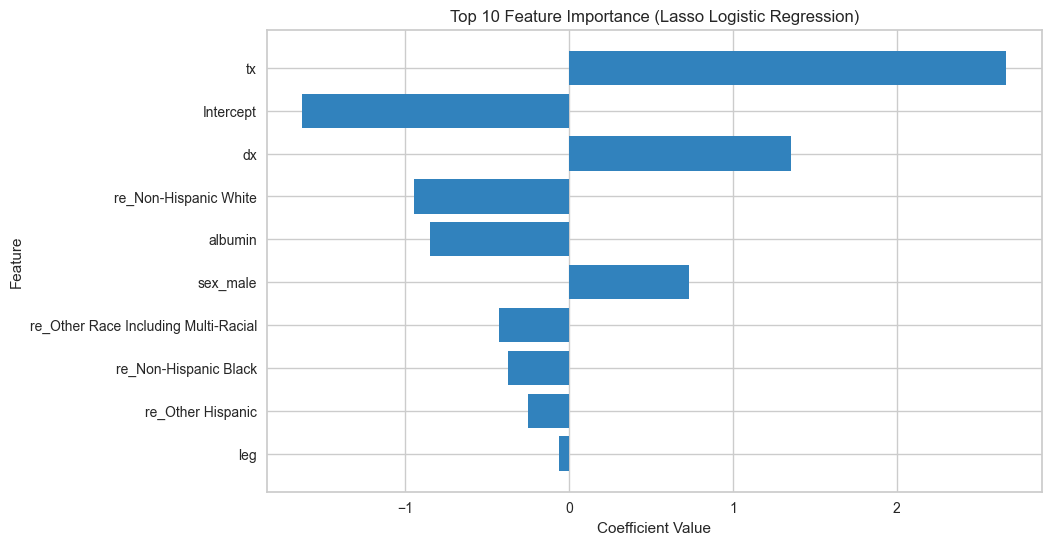

                                 Feature  Coefficient  abs_Coefficient
2                                     tx     2.668073         2.668073
15                             Intercept    -1.628088         1.628088
3                                     dx     1.352477         1.352477
12                 re_Non-Hispanic White    -0.947041         0.947041
9                                albumin    -0.847322         0.847322
10                              sex_male     0.730127         0.730127
14  re_Other Race Including Multi-Racial    -0.423507         0.423507
11                 re_Non-Hispanic Black    -0.368218         0.368218
13                     re_Other Hispanic    -0.249133         0.249133
5                                    leg    -0.060711         0.060711
7                                  waist     0.041442         0.041442
6                                   armc     0.035767         0.035767
0                                    age     0.032907         0.032907
4     

In [34]:
# Get the coefficients from the tuned Lasso Logistic Regression model
coefficients = tuned_lasso_log_reg_model.coef_[0]
intercept = tuned_lasso_log_reg_model.intercept_[0]

# Get the feature names
feature_names = X_train.columns

# Combine the feature names and their corresponding coefficients
coefficients_df = pd.DataFrame({"Feature": feature_names, "Coefficient": coefficients})

# Add the intercept as a row
coefficients_df = coefficients_df.append(
    {"Feature": "Intercept", "Coefficient": intercept}, ignore_index=True
)

# Sort the coefficients by absolute value
coefficients_df["abs_Coefficient"] = np.abs(coefficients_df["Coefficient"])
coefficients_df = coefficients_df.sort_values(by="abs_Coefficient", ascending=False)
# .drop(columns=["abs_Coefficient"])

# Select the top 10 features
top_10_features = coefficients_df.head(10)

# Create the horizontal bar plot for the top 10 features
plt.figure(figsize=(10, 6))
plt.barh(top_10_features["Feature"], top_10_features["Coefficient"], color="#3182bd")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.title("Top 10 Feature Importance (Lasso Logistic Regression)")
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.show()

# Display the coefficients
print(coefficients_df)

Logistic Regression Explanatory Findings:

1. `tx` which indicates whether a person is on insulin or diabetes medications, has the highest positive coefficient. This strong positive relationship suggests that individuals on insulin or diabetes medications are much more likely to have diabetes. This makes intuitive sense as the presence of diabetes treatment is a direct indicator of the condition.

2. `dx` findings of strong positive relationship also makes intuitive sense since a person who has already been diagnosed with Diabetes or is in the PRE-Diabetic stage is more susceptible to having diabetes.

3. The positive coefficient for `sex_male` suggests that being male is associated with a higher likelihood of having diabetes compared to females.

4. The length of the upper leg (`leg`) has a small negative coefficient, indicating a slight negative association with the likelihood of having diabetes. However, this feature has a relatively minor impact compared to others.


PermutationExplainer explainer: 1001it [00:34, 20.92it/s]                         


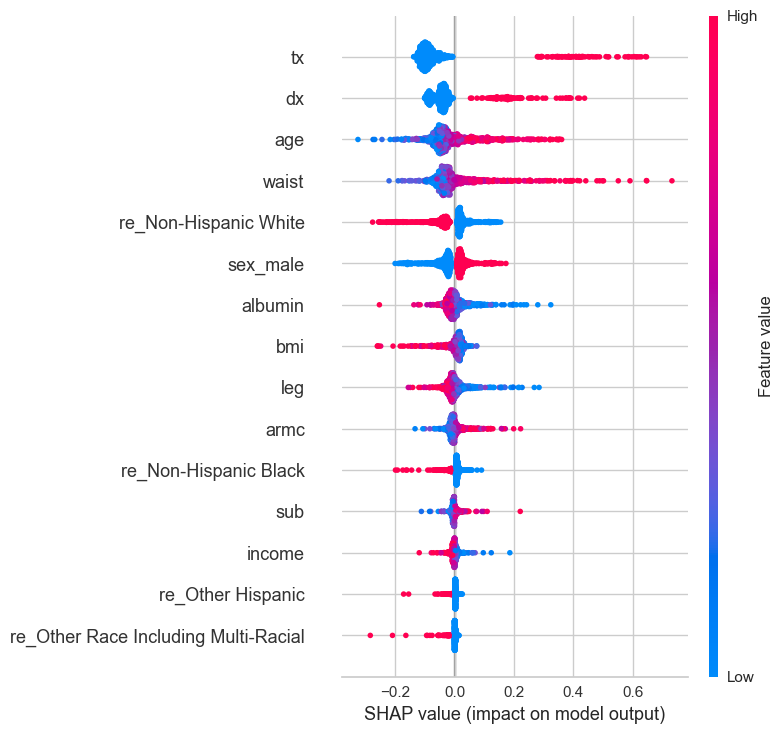

In [78]:
# Use SHAP to explain the model's predictions
explainer = shap.Explainer(tuned_lasso_log_reg_model.predict, X_train)
shap_values = explainer(X_test[:1000])
# Plot the SHAP summary plot
shap.summary_plot(
    shap_values,
    X_test[:1000],
)

In [42]:
cleaned_df[cleaned_df["has_diabetes"] == 1].bmi.describe()

count    628.000000
mean      33.034443
std        7.430202
min       17.260000
25%       27.842500
50%       31.680000
75%       36.762500
max       81.250000
Name: bmi, dtype: float64

In [43]:
cleaned_df[cleaned_df["has_diabetes"] == 0].bmi.describe()

count    6167.000000
mean       27.841836
std         6.716954
min        13.180000
25%        23.140000
50%        26.900000
75%        31.240000
max        84.870000
Name: bmi, dtype: float64

## Explanation of SHAP Summary Plot (GLOBAL INTERPRETABILITY)

The SHAP (SHapley Additive exPlanations) summary plot is a powerful tool to understand how different features in your data influence the predictions made by a machine learning model.

### Overview

1. **Features**:

   - The y-axis lists the features from your dataset, ranked by their importance. The top features are the most influential in predicting the target outcome.

2. **SHAP Values**:

   - The x-axis represents the SHAP values, which show the impact of each feature on the model's prediction. Positive SHAP values push the prediction towards a positive outcome (e.g., having diabetes) to the right, while negative SHAP values push the prediction towards a negative outcome (e.g., not having diabetes) to the left.

3. **Color Gradient**:
   - The color gradient from blue to red indicates the feature value. Blue represents low feature values, while red represents high feature values. This helps to see how the value of the feature affects the prediction.

### Key Features and Their Impact

1. **`tx` (On Insulin or Diabetes Meds)**:

   - **Impact**: High positive SHAP values.
   - **Interpretation**: People on insulin or diabetes medications (high feature value, shown in red) have a much higher likelihood of being predicted to have diabetes.

2. **`dx` (Diagnosed with Diabetes or Pre-Diabetes)**:

   - **Impact**: High positive SHAP values.
   - **Interpretation**: A diagnosis of diabetes or pre-diabetes strongly increases the likelihood of being predicted to have diabetes.

3. **`age`**:

   - **Impact**: Mixed SHAP values.
   - **Interpretation**: Both low and high values of age have varied impacts on the prediction. Older age tends to increase the likelihood of diabetes (red points on the right), while younger age has a lower impact.

4. **`waist` (Waist Circumference)**:

   - **Impact**: Mixed SHAP values.
   - **Interpretation**: Higher waist circumference (shown in red) generally increases the likelihood of being predicted to have diabetes.

5. **`re_Non-Hispanic White`**:

   - **Impact**: Negative SHAP values.
   - **Interpretation**: Being Non-Hispanic White is associated with a lower likelihood of being predicted to have diabetes.

6. **`sex_male`**:

   - **Impact**: Positive SHAP values.
   - **Interpretation**: Being male increases the likelihood of being predicted to have diabetes.

7. **`albumin`**:

   - **Impact**: Mixed SHAP values.
   - **Interpretation**: Lower albumin levels (blue points on the right) increase the likelihood of diabetes, while higher levels (red points) decrease it.

8. **`leg` (Upper Leg Length)**:

   - **Impact**: Negative SHAP values.
   - **Interpretation**: Shorter upper leg length tends to decrease the likelihood of being predicted to have diabetes.

9. **`bmi` (Body Mass Index)**:

   - **Impact**: Mixed SHAP values.
   - **Interpretation**: Surprisingly Higher BMI does not really increase the likelihood, which is congruent with the initial coefficient findings (log-odd risks that BMI may not play the most pivotal role in diabetes prediction).

10. **`armc` (Arm Circumference)**:
    - **Impact**: Mixed SHAP values.
    - **Interpretation**: Higher arm circumference generally increases the likelihood of diabetes.

### Conclusion

- **Positive SHAP Values**: Indicate that higher feature values (e.g., being on diabetes medication, higher waist circumference) increase the likelihood of being predicted to have diabetes.
- **Negative SHAP Values**: Indicate that higher feature values (e.g., being Non-Hispanic White, higher albumin levels) decrease the likelihood of being predicted to have diabetes.
- **Color Gradient**: Helps to understand the effect of feature values. For example, high values of `tx` (shown in red) strongly push the prediction towards diabetes.

This plot provides a comprehensive view of how each feature influences the model's predictions, helping us to understand the logistic regression (lasso penalty) model's decision-making process.


## Explanation of SHAP FORCE Plot (LOCAL INTERPRETABILITY)


In [79]:
shap.initjs()

In [80]:
# Plot the SHAP force plot for the first POSITIVE prediction
# Case Study Respondent's Anonymised CASE ID: 19
shap.force_plot(shap_values[19])

### What is a SHAP Force Plot?

A SHAP force plot helps explain how different features (inputs) of a single case (individual) influence the prediction made by a machine learning model. It shows the contribution of each feature to the final prediction.

### How to Read the Plot:

1. **Base Value**: This is the starting point (average prediction) for the model, shown at the center of the plot.
2. **SHAP Values**: The colored bars (red and blue) represent the SHAP values for each feature.
   - **Red Bars**: Features that push the prediction higher (towards having diabetes).
   - **Blue Bars**: Features that push the prediction lower (away from having diabetes).
3. **Feature Contributions**: Each bar is labeled with the feature and its value (e.g., `waist = 110.9`). The length of the bar shows the strength of that feature's contribution.
4. **Final Prediction**: The combined effect of all features results in the final prediction, shown at the end of the plot (e.g., `f(x) = 1.00`).

### Example Interpretation:

- **Case ID 19**:
  - **Positive Prediction**: The final prediction is 1.00, indicating diabetes.
  - **Contributing Features**:
    - **`tx = 1` (On Insulin/Diabetes Meds)**: Strongly pushes the prediction towards diabetes.
    - **`dx = 1` (Diagnosed with Diabetes/Pre-Diabetes)**: Also strongly pushes the prediction towards diabetes.
    - **`age = 71.42`**: Older age contributes positively to the prediction.
    - **`waist = 110.9`**: Higher waist circumference contributes positively to the prediction.
    - **`re_Non-Hispanic White`**: This feature slightly pushes the prediction away from diabetes.

In summary, the SHAP force plot shows how specific features of an individual case influence the model's prediction, helping to understand why the model made that particular prediction.

Similarly, the NEGATIVE CASE (NOT PREDICTED DIABETES) can be interpreted by the plot below:


In [55]:
# Plot the SHAP force plot for the first NEGATIVE prediction
# Case Study Respondent's Anonymised CASE ID: 89
shap.force_plot(shap_values[89])

CASE 89, is predicted to not have diabetes since the individual does not take any insulin/diabetic meds, not diagnosed with DM or pre-DM, is relatively young, and has aveage waist and higher albumin levels


### We perform brief explanatory performance findings on the other 2 NON-best models (Random Forest and Decision Tree model)


**RANDOM FOREST (2ND BEST)**


In [58]:
# Assuming `tuned_rf_model` is your tuned Random Forest model and `X_train` is your training dataset
feature_importances = tuned_rf_model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for better visualization
importances_df = pd.DataFrame(
    {"Feature": feature_names, "Importance": feature_importances}
)
importances_df = importances_df.sort_values(by="Importance", ascending=False)

# Display the top features
importances_df.head(10)

,Feature,Importance
2,tx,0.310490
3,dx,0.263112
0,age,0.131365
7,waist,0.091159
4,bmi,0.060074
8,sub,0.037518
6,armc,0.035878
5,leg,0.026098
9,albumin,0.021535
1,income,0.008357


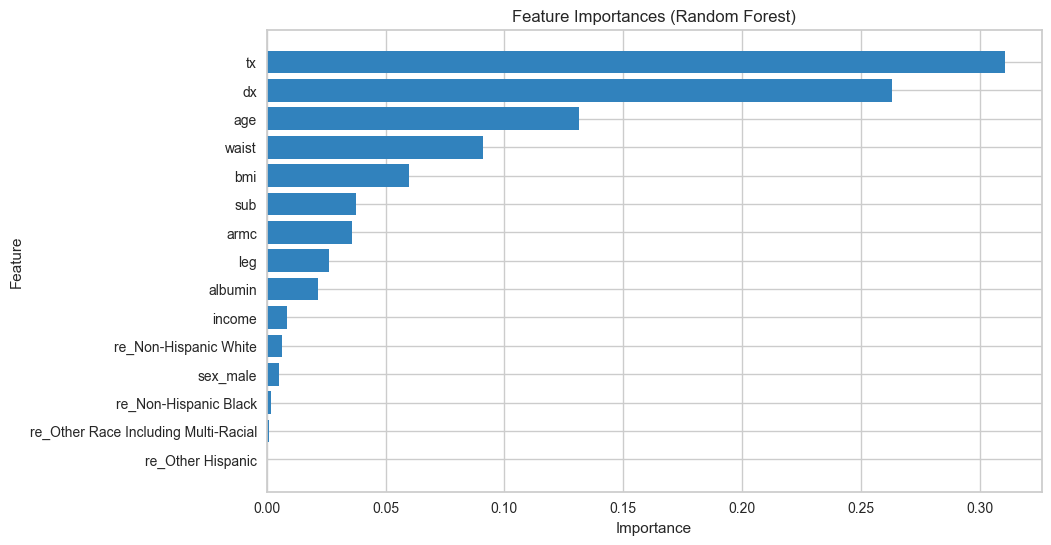

In [59]:
# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importances_df["Feature"], importances_df["Importance"], color="#3182bd")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importances (Random Forest)")
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

PermutationExplainer explainer: 1001it [15:53,  1.03it/s]                          


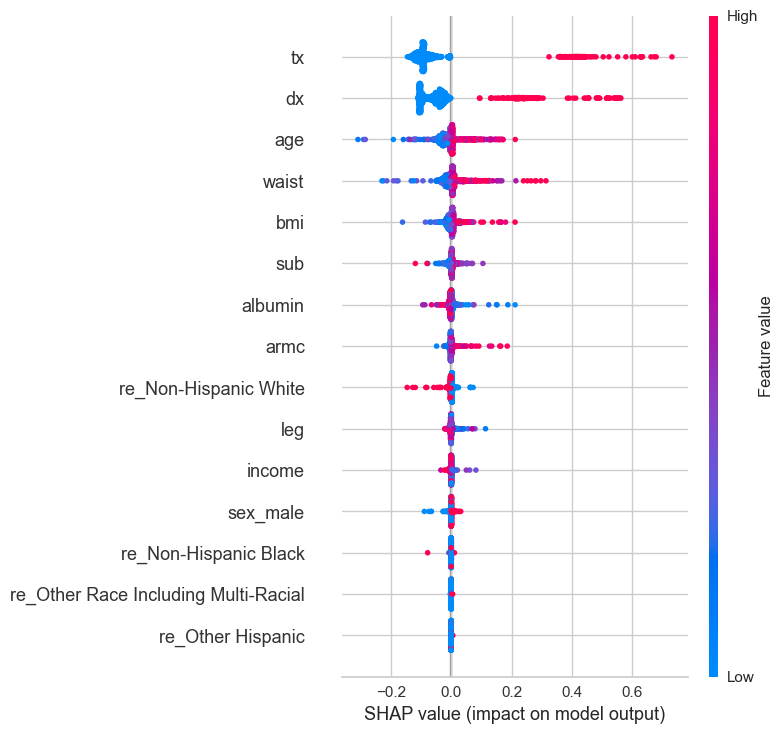

In [67]:
# Use SHAP to explain the model's predictions
explainer = shap.Explainer(tuned_rf_model.predict, X_train)
shap_values = explainer(X_test[:1000])
# Plot the SHAP summary plot
shap.summary_plot(
    shap_values,
    X_test[:1000],
)

## Interesting differences observed

It seems like in terms of explainability, the Random Forest and Lasso Logistic Regression model differ in terms of the features they prioritised and interpret. A distinct example is that being an individual's gender is not so important for random forest, but more influential in lasso logistic regression. Apart from that bmi plays a more important role for random forest, with higher values increasing the risk of diabetes. This is the opposite of logistic regression, which tells a different story as it seems like higher bmi readings lead to lower risk.

# Explaining the Differences

1. **Model Structure**:

   - **Lasso Logistic Regression**: This is a linear model that assumes a linear relationship between the features and the target variable. It uses L1 regularization to shrink some coefficients to zero, effectively performing feature selection.
   - **Random Forest**: This is an ensemble model that consists of multiple decision trees. It can capture complex, non-linear relationships between the features and the target variable. Each tree is built on a different subset of the data, which can result in different features being important in different trees.

2. **Feature Importance Calculation**:

   - **Lasso Logistic Regression**: The importance of a feature is directly related to the magnitude of its coefficient. Features with larger absolute coefficients have a larger impact on the prediction.
   - **Random Forest**: The importance of a feature is determined by how much it reduces uncertainty (impurity) across all the trees. This means that features that are useful for splitting the data at different points in different trees will be deemed important, even if they don't have a large effect on the prediction in a linear sense.

3. **Handling of Correlated Features**:
   - **Lasso Logistic Regression**: Tends to select one feature among a group of highly correlated features and shrink the coefficients of the others to zero. This results in fewer features being selected.
   - **Random Forest**: Can utilize all correlated features simultaneously because it uses different subsets of features in different trees. This can result in multiple correlated features being deemed important.


**DECISION TREE MODEL (3RD BEST MODEL)**


PermutationExplainer explainer: 1001it [00:28, 22.93it/s]                          


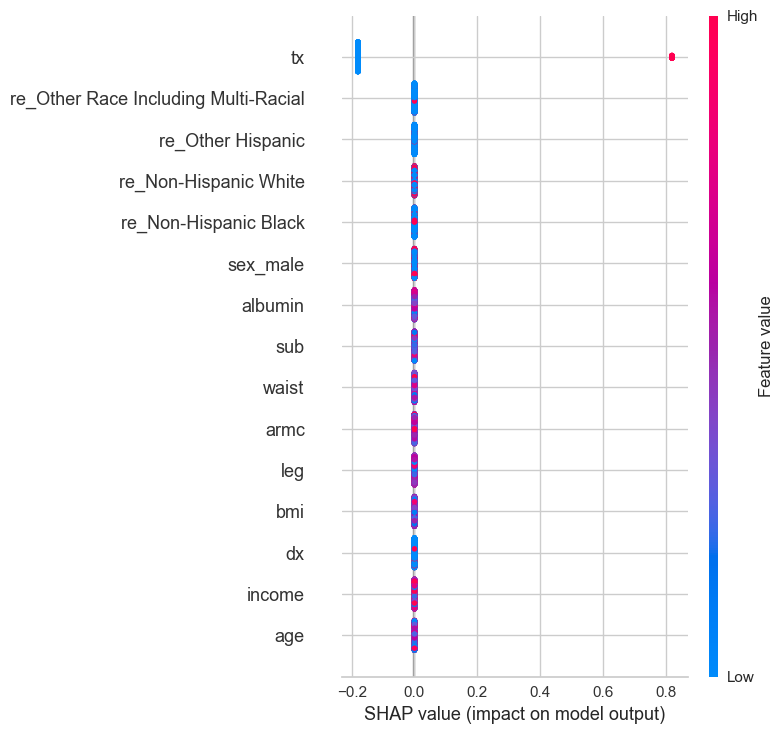

In [74]:
# Use SHAP to explain the model's predictions
explainer = shap.Explainer(tuned_dt_model.predict, X_train)
shap_values = explainer(X_test[:1000])
# Plot the SHAP summary plot
shap.summary_plot(
    shap_values,
    X_test[:1000],
)

## **Conclusion**

### **RECAP OF Research objectives**

The main objective of this research is to develop 3 Machine Learning Models which are able to predict those with diabetes (gh >= 6.5%) with the best predictability rate. The end-user of this ML system will be the medical professionals and potentially the patients who would like to know whether they could be having diabetes. By accurately predicting diabetes, this predictive models will help to ensure prompt intervention on patients with diabetes, thus ensuring better life outcomes for the patients and avert uncecessary further financial burden due to delayed treatment. I will also adopt the use of an Explainable-AI tool, which in my case is the SHAP, which stands for SHapley Additive exPlanations, which is to provide interpretable insights on how each of the feature impacts the model's decision making process. The benefit of such is that it can also educate the end-users on some of the key reasons and trends of identifying diabetes based on the unique attributes of patients. At the same time, it provides a human-over-the-loop monitoring for the team of data scientists/engineers to verify the decision-making process of the ML models, to ensure the ethics of AI and transparency of AI are upheld, especially important for the health sector. This is important to avert any biases in the model prediction.

**Predictive Performance (On test dataset) conclusion:**

| Model                     | Accuracy | AUC      | Recall   | Precision | F1 Score |
| ------------------------- | -------- | -------- | -------- | --------- | -------- |
| Lasso Logistic Regression | 0.904855 | 0.946421 | 0.829787 | 0.490566  | 0.616601 |
| Decision Tree             | 0.944090 | 0.818670 | 0.664894 | 0.710227  | 0.686813 |
| Random Forest             | 0.920549 | 0.939550 | 0.760638 | 0.550000  | 0.638393 |

1. Logistic Regression (Lasso-Penalised): I conclude that this is the best model, with the highest AUC score of 0.946 and highest Recall Score of 0.830 when fine-tuned and regularised to prevent overfitting. It is also highly interpretable.

2. Random Forest: I conclude that Random Forest Classifier is the second best model, with second highest AUC score and a decent recall of 0.761.

3. Decision Tree: Decision tree is the worst performing, with an AUC score being lowest and the recall score also the lowest. However, this is not to discredit this model as it is also highly explainable/interpretable. The AUC score and recall score can still be considered decent

**Conclusively, Logistic Regression (With Lasso Penalty) performs the best in terms of predictive performance.**

### **EXPLANATORY PERFORMANCE**

The differences in feature importance and SHAP plots between the Lasso Logistic Regression and the Random Forest/decision tree models are due to:

- The linear vs. non-linear nature of the models.
- The different methods of calculating feature importance.
- The handling of correlated features.

Consolidating the General findings from the lasso logistic regression model and random forest model SHAP models suggest that the following factors increases your risk of diabetes:

1. `tx` = 1, being treated with insulin/on diabetes med increases one risk of diabetes.

2. `dx` = 1, being diagnosed with PRE-DM or already diagnosed with DM increases risk of diabetes.

3. A higher `age`, being older, increases one's risk of diabetes.

4. A higher waistline circumference increases one's risk of diabetes.

5. If you are male individual, you are at an elevated risk of diabetes.

6. A lower income level may also elevate your risk of diabetes.

7. Having a lower albumin level also increases your risk of diabetes

**Conclusively, BOTH Logistic Regression (With Lasso Penalty) and RANDOM FOREST is a tie in terms of predictive performance since their decision making process is relatively different due to the linear (log reg) vs. non-linear (random forest) nature of the models.**
